In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os,sys
from PIL import Image
import albumentations as albu
import cv2
import helper
import pandas as pd 
import h5py
import skimage.color as color
import augmentation as augment
import models as mod
import keras
import submission as sub
import math as math
from keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Loading the dataset

In [2]:
# Loaded a set of images
root_dir = "Datasets/training/"

n = 100

imgs = []
gt_imgs = []

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
print("Loading " + str(n) + " images")
imgs = [helper.load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [helper.load_image(gt_dir + files[i]) for i in range(n)]

Loading 100 images
Loading 100 images


In [3]:
n = 50
patch_size = 16

img_test = []

for i in range(1, 51):
    image_filename = 'Datasets/test_set_images/test_' + str(i) + '/test_' + str(i) + '.png' 
    img_test.append(helper.load_image(image_filename))

img_patches_test = [helper.img_crop(img_test[i], patch_size, patch_size) for i in range(n)]
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

In [5]:
img_patches = augment.patcher_3000(imgs[1], 16, 100)
#gt_patches = helper.img_crop(gt_imgs[1], 16, 16)

# Linearize list of patches
#img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
#gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [11]:
imgspat, _  = augment.extract_patches(imgs, gt_imgs)

In [14]:
print(imgspat[1].shape)

(16, 16, 3)


In [7]:
len(img_patches)

625

In [15]:
print(img_patches[1].shape)

(100, 100, 3)


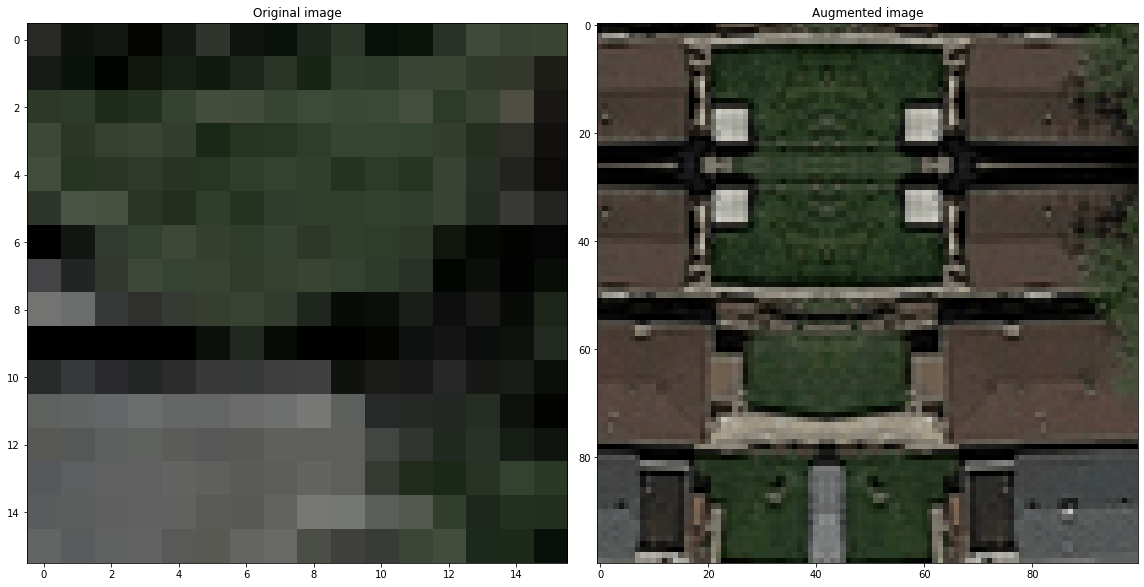

In [17]:
augment.show(imgspat[1], img_patches[1])

# Data pre-processing

## Data augmentation 

In [19]:
"Types of augmentation"
#light & medium need uint8 imgs ! 
light = albu.Compose([albu.RandomBrightnessContrast(p=1),albu.RandomGamma(p=1), albu.CLAHE(p=1)], p=1)

medium = albu.Compose([albu.CLAHE(p=1), albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1)], p=1)

strong = albu.Compose([albu.ChannelShuffle(p=1)], p=1)
    
grid_shuffle = albu.RandomGridShuffle(grid=(5, 5), always_apply=False, p=1)

#### original

In [20]:
img_patches, gt_patches = augment.extract_patches(imgs, gt_imgs)
y = to_categorical(gt_patches) #for categorical_crossentropy

#### rotation set 

In [21]:
img_rot, gt_rot = augment.rotation(imgs, gt_imgs, rg = 55, times = 8)
imgrot_patches, gtrot_patches = augment.extract_patches(img_rot, gt_rot)
yrot = to_categorical(gtrot_patches) #for categorical_crossentropy

#### elastic set

In [22]:
img_elastic, gt_elastic = augment.elastic(imgs, gt_imgs, x = 13)
imgelast_patches, gtelast_patches = augment.extract_patches(img_elastic, gt_elastic)
yelastic = to_categorical(gtelast_patches) #for categorical_crossentropy

#### grid shuffle set

In [23]:
img_shuffle, gt_shuffle = augment.transform(grid_shuffle, imgs, gt_imgs, convert = False, times = 11)
imgshuffle_patches, gtshuffle_patches = augment.extract_patches(img_shuffle, gt_shuffle)
yshuffle = to_categorical(gtshuffle_patches) #for categorical_crossentropy

#### All adds

In [24]:
imgs_all = imgs + img_rot[-8:] + img_elastic[-13:] + img_shuffle[-11:]
gt_all = gt_imgs + gt_rot[-8:] + gt_elastic[-13:] + gt_shuffle[-11:]

imgsall_patches, gtall_patches = augment.extract_patches(imgs_all, gt_all)
yall = to_categorical(gtall_patches)

# CNN

## Training

In [25]:
typesbin = ['SoftmaxBinary','SigmoidBinary']
typescat = ['SoftmaxCategorical', 'SigmoidCategorical']
data = ['original', 'rotated','elastic', 'shuffled','all']
databinary = [[img_patches,gt_patches],[imgrot_patches,gtrot_patches],[imgelast_patches,gtelast_patches],[imgshuffle_patches,gtshuffle_patches], [imgsall_patches, gtall_patches]]
datacateg = [[img_patches,y],[imgrot_patches,yrot],[imgelast_patches,yelastic],[imgshuffle_patches,yshuffle],[imgsall_patches,yall]]

### Model 1 

In [12]:
model1 = pd.DataFrame()
batch_size = 64 

for i,typ in enumerate(typescat): 
    M1 = mod.model1(typ)
    M1.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy'])
    for j, dat in enumerate(datacateg): 
        m1Hist = M1.fit(dat[0],dat[1],epochs=5, validation_split = 0.2)
        model1.append(m1Hist.history['val_accuracy'])
        
        predictions = M1.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model1_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)
   

Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 83s 2ms/step - loss: 0.5664 - accuracy: 0.6900 - val_loss: 0.5815 - val_accuracy: 0.6747
Epoch 2/5
50000/50000 [==============================] - 87s 2ms/step - loss: 0.5082 - accuracy: 0.7350 - val_loss: 0.5499 - val_accuracy: 0.7265
Epoch 3/5
50000/50000 [==============================] - 89s 2ms/step - loss: 0.4702 - accuracy: 0.7663 - val_loss: 0.5039 - val_accuracy: 0.7611
Epoch 4/5
50000/50000 [==============================] - 92s 2ms/step - loss: 0.4403 - accuracy: 0.7870 - val_loss: 0.4775 - val_accuracy: 0.7720
Epoch 5/5
50000/50000 [==============================] - 94s 2ms/step - loss: 0.4103 - accuracy: 0.8072 - val_loss: 0.4777 - val_accuracy: 0.7794
Train on 54000 samples, validate on 13500 samples
Epoch 1/5
54000/54000 [==============================] - 107s 2ms/step - loss: 0.3947 - accuracy: 0.8182 - val_loss: 0.4422 - val_accuracy: 0.7988
Epoch 2/5
54000/54000 [

ValueError: Error when checking target: expected dense_3 to have shape (1,) but got array with shape (2,)

In [33]:
typ = 'SigmoidCategorical'
M1 = mod.model1(typ)
M1.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy'])
for j, dat in enumerate(datacateg): 
    m1Hist = M1.fit(dat[0],dat[1],epochs=5, validation_split = 0.2)
    model1.append(m1Hist.history['val_accuracy'])
    predictions = M1.predict(img_patches_test)
    predictions = np.squeeze(helper.binarize_predictions(predictions))
    predictions = predictions[:,1]
    sub.create_pred_images(predictions)
    submission_filename = 'model1_{0}_{1}.csv'.format(typ,data[j])
    sub.create_submission(submission_filename)

Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 82s 2ms/step - loss: 0.5754 - accuracy: 0.6825 - val_loss: 0.5723 - val_accuracy: 0.6742
Epoch 2/5
50000/50000 [==============================] - 88s 2ms/step - loss: 0.5139 - accuracy: 0.7296 - val_loss: 0.5426 - val_accuracy: 0.7517
Epoch 3/5
50000/50000 [==============================] - 91s 2ms/step - loss: 0.4543 - accuracy: 0.7798 - val_loss: 0.4809 - val_accuracy: 0.7678
Epoch 4/5
50000/50000 [==============================] - 94s 2ms/step - loss: 0.4184 - accuracy: 0.8036 - val_loss: 0.4664 - val_accuracy: 0.7755
Epoch 5/5
50000/50000 [==============================] - 90s 2ms/step - loss: 0.3995 - accuracy: 0.8137 - val_loss: 0.4838 - val_accuracy: 0.7782
File 'model1_SigmoidCategorical_original.csv' created
Train on 54000 samples, validate on 13500 samples
Epoch 1/5
54000/54000 [==============================] - 103s 2ms/step - loss: 0.3868 - accuracy: 0.8211 - val_loss:

In [ ]:
for i,typ in enumerate(typesbin): 
    M1 = mod.model1(typ)
    M1.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy', f1_m])
    for j, dat in enumerate(databinary): 
        m1Hist = M1.fit(dat[0],dat[1], epochs=5, validation_split = 0.2)
        model1.append(m1Hist.history['val_accuracy'])
        predictions = M1.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model1_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)

### Model 2

In [ ]:
model2 = pd.DataFrame()
batch_size = 64 

for i,typ in enumerate(typescat): 
    M2 = mod.model2(typ)
    M2.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy'])
    for j, dat in enumerate(datacateg): 
        m2Hist = M2.fit(dat[0],dat[1],epochs=5, validation_split = 0.2)
        model2.append(m2Hist.history['val_accuracy'])
        
        predictions = M2.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model2_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)


Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 89s 2ms/step - loss: 0.5781 - accuracy: 0.6808 - val_loss: 0.5915 - val_accuracy: 0.6591
Epoch 2/5
50000/50000 [==============================] - 91s 2ms/step - loss: 0.5162 - accuracy: 0.7290 - val_loss: 0.5228 - val_accuracy: 0.7582
Epoch 3/5
50000/50000 [==============================] - 94s 2ms/step - loss: 0.4702 - accuracy: 0.7659 - val_loss: 0.4987 - val_accuracy: 0.7744
Epoch 4/5
50000/50000 [==============================] - 94s 2ms/step - loss: 0.4231 - accuracy: 0.7988 - val_loss: 0.5031 - val_accuracy: 0.7526
Epoch 5/5
50000/50000 [==============================] - 95s 2ms/step - loss: 0.3880 - accuracy: 0.8219 - val_loss: 0.4460 - val_accuracy: 0.8010
File 'model2_SoftmaxCategorical_original.csv' created
Train on 54000 samples, validate on 13500 samples
Epoch 1/5
54000/54000 [==============================] - 109s 2ms/step - loss: 0.3690 - accuracy: 0.8315 - val_loss:

In [11]:
model22 = pd.DataFrame()
batch_size = 64 

#for i,typ in enumerate(typescat): 
typ = 'SigmoidCategorical' 
M2 = mod.model2(typ)
M2.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy'])
for j, dat in enumerate(datacateg): 
    m2Hist = M2.fit(dat[0],dat[1],epochs=5, validation_split = 0.2)
    model22.append(m2Hist.history['val_accuracy'])
        
    predictions = M2.predict(img_patches_test)
    predictions = np.squeeze(helper.binarize_predictions(predictions))
    predictions = predictions[:,1]
    sub.create_pred_images(predictions)
    submission_filename = 'model2_{0}_{1}.csv'.format(typ,data[j])
    sub.create_submission(submission_filename)

Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5702 - accuracy: 0.6897 - val_loss: 0.5795 - val_accuracy: 0.6860
Epoch 2/5
50000/50000 [==============================] - 110s 2ms/step - loss: 0.4884 - accuracy: 0.7559 - val_loss: 0.5101 - val_accuracy: 0.7508
Epoch 3/5
50000/50000 [==============================] - 112s 2ms/step - loss: 0.4414 - accuracy: 0.7910 - val_loss: 0.4679 - val_accuracy: 0.7786
Epoch 4/5
50000/50000 [==============================] - 111s 2ms/step - loss: 0.4086 - accuracy: 0.8087 - val_loss: 0.4730 - val_accuracy: 0.7926
Epoch 5/5
50000/50000 [==============================] - 112s 2ms/step - loss: 0.3795 - accuracy: 0.8266 - val_loss: 0.4666 - val_accuracy: 0.7922
File 'model2_SigmoidCategorical_original.csv' created
Train on 54000 samples, validate on 13500 samples
Epoch 1/5
54000/54000 [==============================] - 121s 2ms/step - loss: 0.3671 - accuracy: 0.8335 - val_

In [27]:
model222 = pd.DataFrame()
batch_size = 64 

for i,typ in enumerate(typesbin): 
    M2 = mod.model2(typ)
    M2.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy', helper.f1_m])
    for j, dat in enumerate(databinary): 
        m2Hist = M2.fit(dat[0],dat[1], epochs=2, validation_split = 0.2)
        model222.append(m2Hist.history['val_accuracy'])  
        
        predictions = M2.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions.reshape(-1)
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model2_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)

Train on 50000 samples, validate on 12500 samples
Epoch 1/2
50000/50000 [==============================] - 89s 2ms/step - loss: 10.3211 - accuracy: 0.3269 - f1_m: 0.4868 - val_loss: 10.2671 - val_accuracy: 0.3304 - val_f1_m: 0.4390
Epoch 2/2
50000/50000 [==============================] - 88s 2ms/step - loss: 10.3211 - accuracy: 0.3269 - f1_m: 0.4869 - val_loss: 10.2671 - val_accuracy: 0.3304 - val_f1_m: 0.4390
(72200,)


IndexError: too many indices for array

### Model 3

In [ ]:
model3 = pd.DataFrame()
batch_size = 64 

for i,typ in enumerate(typescat): 
    M3 = mod.model2(typ)
    M3.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy'])
    for j, dat in enumerate(datacateg): 
        m3Hist = M3.fit(dat[0],dat[1],epochs=5, validation_split = 0.2)
        model3.append(m3Hist.history['val_accuracy'])
        
        predictions = M3.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model3_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)

for i,typ in enumerate(typesbin): 
    M3 = mod.model3(typ)
    M3.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy', helper.f1_m])
    for j, dat in enumerate(databinary): 
        m3Hist = M3.fit(dat[0],dat[1], epochs=5, validation_split = 0.2)
        model3.append(m3Hist.history['val_accuracy'])  
        
        predictions = M3.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model3_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)

### Model 4

In [ ]:
model4 = pd.DataFrame()
batch_size = 64 

for i,typ in enumerate(typescat): 
    M4 = mod.model4(typ)
    M4.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy'])
    for j, dat in enumerate(datacateg): 
        m4Hist = M4.fit(dat[0],dat[1],epochs=5, validation_split = 0.2)
        model4.append(m4Hist.history['val_accuracy'])
        
        predictions = M4.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model4_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)

for i,typ in enumerate(typesbin): 
    M4 = mod.model4(typ)
    M4.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-3), metrics = ['accuracy', helper.f1_m])
    for j, dat in enumerate(databinary): 
        m4Hist = M4.fit(dat[0],dat[1], epochs=5, validation_split = 0.2)
        model4.append(m4Hist.history['val_accuracy'])
        
        predictions = M4.predict(img_patches_test)
        predictions = np.squeeze(helper.binarize_predictions(predictions))
        predictions = predictions[:,1]
        sub.create_pred_images(predictions)
        submission_filename = 'model4_{0}_{1}.csv'.format(typ,data[j])
        sub.create_submission(submission_filename)

# PLOTTING 